In [1]:
# Logger
import logging
logging.basicConfig(level=logging.WARN)

# Enable automatic module reload
%load_ext autoreload
%autoreload 2

# Load PyALCS ACSM module
from bacs.agents.bacs import BACS, Configuration
from bacs.agents.bacs.utils.GymMazeWrapper import _maze_metrics, parse_metrics_to_df, plot_performance

# Load environments
import gym
import my_mazes

# Agent - BACS

## Common parameters

In [2]:
CLASSIFIER_LENGTH = 8
NUMBER_OF_POSSIBLE_ACTIONS = 8

MAZE = "MazeE2-v0"

NUMBER_OF_EXPLORE_TRIALS = 5000
METRICS_TRIAL_FREQUENCY_EXPLORE = 100
BETA_EXPLORE = 0.05
EPSILON = 0.8

NUMBER_OF_EXPLOIT_TRIALS_NO_RL = 500
BETA_EXPLOIT_NO_RL = 0.00

NUMBER_OF_EXPLOIT_TRIALS_RL_START = 100
BETA_EXPLOIT_RL_START = 0.05

NUMBER_OF_EXPLOIT_TRIALS_RL = 500
BETA_EXPLOIT_RL = 0.05

LENGTH_OF_BEHAVIORAL_SEQUENCES = 1

## Environment - Maze

In [3]:
# Initialize environment
maze = gym.make(MAZE)
# Reset it, by putting an agent into random position
situation = maze.reset()
# Render the state in ASCII
maze.render()


■ ■ ■ ■ ■ ■ ■ ■ ■
■ □ □ A □ □ □ □ ■
■ □ □ □ □ □ □ □ ■
■ □ □ □ □ □ □ □ ■
■ □ □ □ $ □ □ □ ■
■ □ □ □ □ □ □ □ ■
■ □ □ □ □ □ □ □ ■
■ □ □ □ □ □ □ □ ■
■ ■ ■ ■ ■ ■ ■ ■ ■


## Training of BACS - Exploration

In [4]:
%%time

cfg_explore = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=METRICS_TRIAL_FREQUENCY_EXPLORE,
    do_ga=False,
    do_subsumption=True,
    beta=BETA_EXPLORE,
    gamma=0.95,
    theta_i=0.1,
    theta_r=0.9,
    epsilon=EPSILON,
    u_max=CLASSIFIER_LENGTH,
    theta_exp=20,
    theta_ga=100,
    theta_as=20,
    mu=0.3,
    chi=0.8,
    bs_max=LENGTH_OF_BEHAVIORAL_SEQUENCES
)

agent_explore = BACS(cfg_explore)
population_explore, metrics_explore = agent_explore.explore(maze, NUMBER_OF_EXPLORE_TRIALS)

CPU times: user 11min 22s, sys: 3.96 s, total: 11min 26s
Wall time: 12min 15s


## Exploitation of BACS

### Exploitation without Reinforcement Module

In [5]:
%%time

cfg_exploit_no_rl = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    do_ga=False,
    do_subsumption=True,
    beta=BETA_EXPLOIT_NO_RL,
    gamma=0.95,
    theta_i=0.1,
    theta_r=0.9,
    epsilon=0.0,
    u_max=CLASSIFIER_LENGTH,
    theta_exp=20,
    theta_ga=100,
    theta_as=20,
    mu=0.3,
    chi=0.8,
    bs_max=LENGTH_OF_BEHAVIORAL_SEQUENCES
)

agent_exploit_no_rl = BACS(cfg_exploit_no_rl, population_explore)
agent_exploit_no_rl.clean_population(does_anticipate_change=True)
population_exploit_no_rl, metrics_exploit_no_rl = agent_exploit_no_rl.exploit(maze, NUMBER_OF_EXPLOIT_TRIALS_NO_RL)


CPU times: user 4min 28s, sys: 144 ms, total: 4min 28s
Wall time: 4min 28s


In [6]:
%%time

cfg_exploit_rl_start = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    do_ga=False,
    do_subsumption=True,
    beta=BETA_EXPLOIT_RL_START,
    gamma=0.95,
    theta_i=0.1,
    theta_r=0.9,
    epsilon=0.0,
    u_max=CLASSIFIER_LENGTH,
    theta_exp=20,
    theta_ga=100,
    theta_as=20,
    mu=0.3,
    chi=0.8,
    bs_max=LENGTH_OF_BEHAVIORAL_SEQUENCES
)

agent_exploit_rl_start = BACS(cfg_exploit_rl_start, population_exploit_no_rl)
agent_exploit_rl_start.clean_population(does_anticipate_change=True)
population_exploit_rl_start, metrics_exploit_rl_start = agent_exploit_rl_start.exploit(maze, NUMBER_OF_EXPLOIT_TRIALS_RL_START)


CPU times: user 55.1 s, sys: 29.6 ms, total: 55.2 s
Wall time: 55.2 s


In [7]:
%%time

cfg_exploit_rl = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    do_ga=False,
    do_subsumption=True,
    beta=BETA_EXPLOIT_RL,
    gamma=0.95,
    theta_i=0.1,
    theta_r=0.9,
    epsilon=0.0,
    u_max=CLASSIFIER_LENGTH,
    theta_exp=20,
    theta_ga=100,
    theta_as=20,
    mu=0.3,
    chi=0.8,
    bs_max=LENGTH_OF_BEHAVIORAL_SEQUENCES
)

agent_exploit_rl = BACS(cfg_exploit_rl, population_exploit_rl_start)
agent_exploit_rl.clean_population(does_anticipate_change=True)
population_exploit_rl, metrics_exploit_rl = agent_exploit_rl.exploit(maze, NUMBER_OF_EXPLOIT_TRIALS_RL)

CPU times: user 4min 13s, sys: 132 ms, total: 4min 13s
Wall time: 4min 13s


### Performance

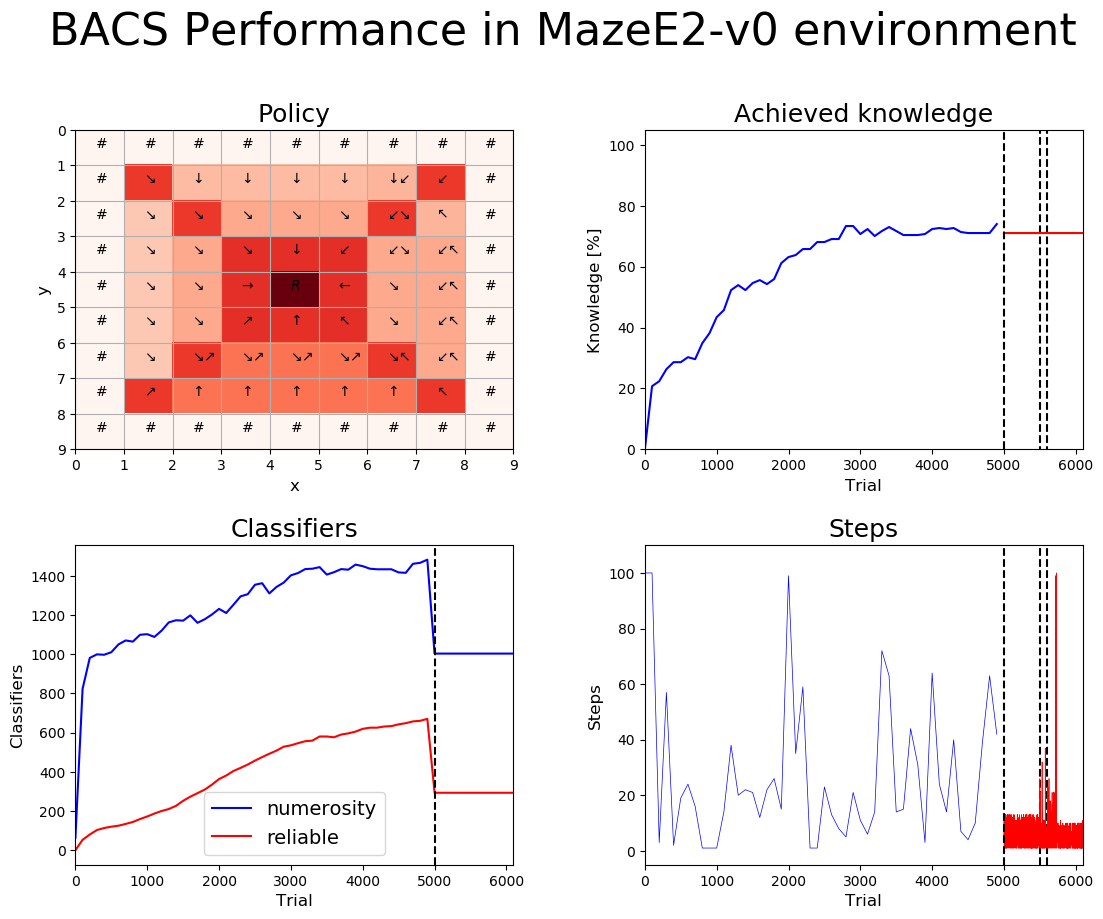

In [8]:
metrics_trial_frequency_explore = cfg_explore.metrics_trial_frequency
metrics_trial_frequency_exploit = 1

metrics_exploit = metrics_exploit_no_rl.copy()
for idx, item in enumerate(metrics_exploit_rl_start):
    tmp = item.copy()
    tmp['trial'] += NUMBER_OF_EXPLOIT_TRIALS_NO_RL
    metrics_exploit.append(tmp)
for idx, item in enumerate(metrics_exploit_rl):
    tmp = item.copy()
    tmp['trial'] += NUMBER_OF_EXPLOIT_TRIALS_NO_RL + NUMBER_OF_EXPLOIT_TRIALS_RL_START
    metrics_exploit.append(tmp)

metrics_df = parse_metrics_to_df(metrics_explore, metrics_trial_frequency_explore, metrics_exploit, metrics_trial_frequency_exploit)
plot_performance(agent_exploit_rl, maze, metrics_df, cfg_exploit_rl, MAZE, metrics_trial_frequency_explore, [NUMBER_OF_EXPLOIT_TRIALS_NO_RL,NUMBER_OF_EXPLOIT_TRIALS_RL_START,NUMBER_OF_EXPLOIT_TRIALS_RL])


In [9]:
avg_step_explore = 0
for trial in metrics_explore:
    avg_step_explore += trial['steps_in_trial']
avg_step_explore /= NUMBER_OF_EXPLORE_TRIALS / metrics_trial_frequency_explore
print("Average number of steps to solve the maze is ",avg_step_explore,
      " for a total of ", NUMBER_OF_EXPLORE_TRIALS, " trials in EXPLORATION")

avg_step_exploit_no_rl = 0
for trial in metrics_exploit_no_rl:
    avg_step_exploit_no_rl += trial['steps_in_trial']
avg_step_exploit_no_rl /= NUMBER_OF_EXPLOIT_TRIALS_NO_RL
print("Average number of steps to solve the maze is ",avg_step_exploit_no_rl,
      " for a total of ", NUMBER_OF_EXPLOIT_TRIALS_NO_RL, " trials in EXPLOITATION without Reinforcement Module")

avg_step_exploit_rl_start = 0
for trial in metrics_exploit_rl_start:
    avg_step_exploit_rl_start += trial['steps_in_trial']
avg_step_exploit_rl_start /= NUMBER_OF_EXPLOIT_TRIALS_RL_START
print("Average number of steps to solve the maze is ",avg_step_exploit_rl_start,
      " for a total of ", NUMBER_OF_EXPLOIT_TRIALS_RL_START, " trials in EXPLOITATION starting Reinforcement Module")

avg_step_exploit_rl = 0
for trial in metrics_exploit_rl:
    avg_step_exploit_rl += trial['steps_in_trial']
avg_step_exploit_rl /= NUMBER_OF_EXPLOIT_TRIALS_RL
print("Average number of steps to solve the maze is ",avg_step_exploit_rl,
      " for a total of ", NUMBER_OF_EXPLOIT_TRIALS_RL, " trials in EXPLOITATION with Reinforcement Module")


Average number of steps to solve the maze is  27.18  for a total of  5000  trials in EXPLORATION
Average number of steps to solve the maze is  5.798  for a total of  500  trials in EXPLOITATION without Reinforcement Module
Average number of steps to solve the maze is  5.28  for a total of  100  trials in EXPLOITATION starting Reinforcement Module
Average number of steps to solve the maze is  5.324  for a total of  500  trials in EXPLOITATION with Reinforcement Module


In [10]:
population_exploit_rl.sort(key=lambda cl: -cl.fitness)
population_exploit_to_display = [cl for cl in population_exploit_rl if cl.behavioral_sequence]
for cl in population_exploit_to_display:
    print(cl)
    #print("{!r} \t {!r} \t {!r} \t {:.3f} \t {:.3f} \t {:.1f} \t {!r} \t {!r}".format(cl.condition, cl.action, cl.effect, cl.fitness, cl.q, cl.num, cl.exp, cl.mark))
    print("\n")

1111###1 5 [5] [('0', '0', '0', '0', '0', '0', '0', '0')] 0000#9#0         (empty)               q: 1.0   r: 950.0  ir: 0.0    f: 950.0  exp: 370 tga: 17020 talp: 136172 tav: 2.19e+02 num: 1


#11111## 7 [7] [('0', '0', '0', '0', '0', '0', '0', '0')] #00000#9         (empty)               q: 1.0   r: 950.0  ir: 0.0    f: 950.0  exp: 282 tga: 36958 talp: 136241 tav: 3.26e+02 num: 1


#0#11111 1 [1] [('0', '0', '0', '0', '0', '0', '0', '0')] #9#00000         (empty)               q: 1.0   r: 950.0  ir: 0.0    f: 950.0  exp: 279 tga: 37066 talp: 136430 tav: 2.97e+02 num: 1


11##0111 3 [3] [('0', '0', '0', '0', '0', '0', '0', '0')] 00#9#000         (empty)               q: 1.0   r: 950.0  ir: 0.0    f: 950.0  exp: 420 tga: 7001  talp: 136190 tav: 3.38e+02 num: 1


009#00#0 0 [3] [('1', '1', '0', '0', '0', '0', '0', '1')] ##0#####         (empty)               q: 0.985 r: 957.0  ir: 956.2  f: 943.1  exp: 61  tga: 2642  talp: 132520 tav: 2.46e+03 num: 1


11#0#111 3 [3] [('0', '0', '0', '0'

##0#1#00 6 [1] [('0', '0', '0', '1', '1', '1', '0', '0')] ###00011         (00011100)            q: 0.15  r: 238.6  ir: 0.0    f: 35.89  exp: 29  tga: 106969 talp: 136412 tav: 4.18e+03 num: 1


###000## 3 [0] [('0', '0', '0', '0', '0', '0', '0', '0')] 11#111#1         (0{09}00000{09})      q: 0.387 r: 92.62  ir: 0.0    f: 35.83  exp: 5   tga: 135725 talp: 136221 tav: 2.27e+04 num: 1


#0#00000 5 [5] [('0', '0', '0', '0', '0', '0', '0', '0')] ###11111         (00000000)            q: 0.392 r: 90.47  ir: 0.0    f: 35.47  exp: 5   tga: 135002 talp: 136348 tav: 2.27e+04 num: 1


#00000## 3 [7] [('0', '0', '0', '0', '0', '0', '0', '0')] #11111#9         (empty)               q: 0.107 r: 325.2  ir: 0.0    f: 34.9   exp: 28  tga: 131548 talp: 136421 tav: 4.31e+03 num: 1


1#00#001 3 [7] [('0', '0', '0', '0', '0', '0', '0', '0')] #111####         (empty)               q: 0.179 r: 194.6  ir: 0.0    f: 34.87  exp: 23  tga: 124573 talp: 135788 tav: 5.54e+03 num: 1


00000000 7 [1] [('0', '0', '0'